Практика по Кластеризации

Необходимо проанализировать клиентов торгового центра и выделить разные группы покупателей. чтобы понять, как дальше развивать услуги торгового центра, магазины каких сегментов открывать

In [55]:
# импорт библиотек
import pandas as pd
from sklearn import preprocessing

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [56]:
# загрузка данных
df = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/f60995f3c75188d00b1c97483dd0037d/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/segmented_customers.zip')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19.0,15.0,39.0
1,2,Male,21.0,15.0,81.0
2,3,Female,20.0,16.0,6.0
3,4,Female,23.0,16.0,77.0
4,5,Female,31.0,17.0,40.0


Предобработка данных

In [57]:
# ищем пропуски в датасете
df[df.isna().any(axis=1)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
200,201,Female,21.0,NaN,40.0
201,202,Female,30.0,127.0,NaN
202,203,Male,80.0,NaN,20.0
203,204,Male,NaN,16.0,120.0
204,205,Female,NaN,9.0,80.0


In [58]:
# удаляем данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df = df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', })

In [59]:
# проверка на дубликаты
df[df.duplicated(subset='customer_id')]

,customer_id,gender,age,annual_income,spending_score


Визуально оцениваем результаты по трем признакам

In [60]:
import plotly
import plotly.express as px

# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

Напишем функцию для визуализации результатов

In [61]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

Признаки, которые будем использовать для кластеризации хохраним в переменную

In [62]:
X = df[['age', 'annual_income', 'spending_score']]

Пробуем провести DBSCAN-кластеризацию со значениями по умолчанию

In [63]:
# импортируем DBSCAN-кластеризацию
from sklearn.cluster import DBSCAN

dbscan_clust = DBSCAN()
dbscan_clust.fit(X)
dbscan_clust_predict = dbscan_clust.labels_

get_3d_visualization(X, dbscan_clust_predict)

Так как данные разрежённые и неоднородные, применять DBSCAN будет сложно, нужно будет подбирать параметры для кластеризации.  
Кластеризация со значениями поумолчанию посчитала всё выбросами.

In [64]:
dbscan_clust = DBSCAN(eps=11, min_samples=5)
dbscan_clust.fit(X)
df['dbscan_res_eps_11'] = dbscan_clust.labels_

get_3d_visualization(X, df['dbscan_res_eps_11'])

Проводим агломеративную кластеризацию и построим дендрограмму. По ней определим количество кластеров, на которые можно разделить датасет.

In [65]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

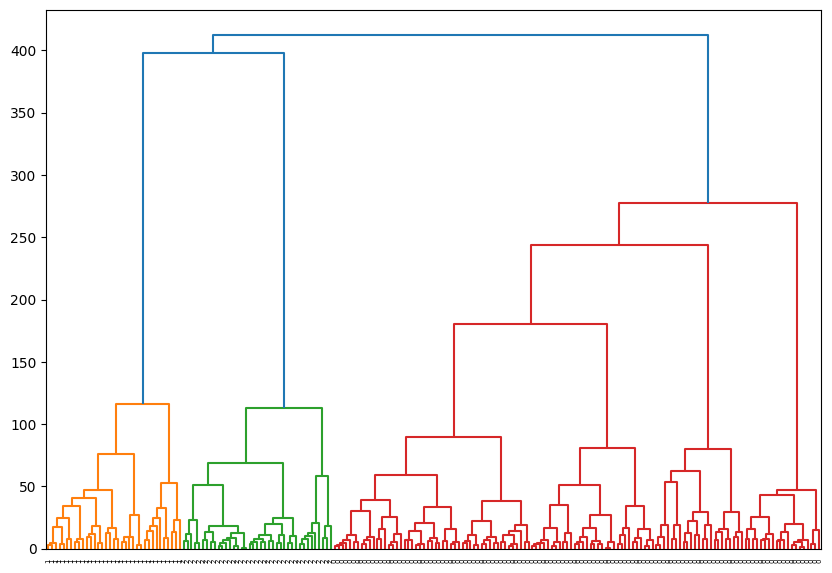

In [72]:
df['aggl_res_3'] = get_aggl_clustering(X, 3)

linked = linkage(X, 'ward')
plt.figure(figsize=(10, 7))

# визуализируем дендрограмму с ориентацией top
# сначала будут отрисовываться кластеры с минимальным расстоянием между ними
dendrogram(linked,
            orientation='top',
            labels=df['aggl_res_3'].to_list(),
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

In [73]:
# обучим модель на аггломеративной кластеризации с 6 кластерами
df['aggl_res_6'] = get_aggl_clustering(X, 6)

get_3d_visualization(df, 'aggl_res_6')